In [1]:
import torch
print(torch.__version__)
print("CUDA:", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.5.1+cu121
CUDA: True
NVIDIA GeForce RTX 4060 Ti


In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder

from torch_geometric.data import Data

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch.optim import Adam

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    recall_score,
    fbeta_score,
    roc_curve
)

In [3]:
import joblib
from joblib import load
df = joblib.load(r'C:\Users\user\Desktop\ML & DL projects\Anti- Money Laundering classification\dataset_joblib_files\dataset_autoencoder.joblib')

In [4]:
# Encode account IDs into node indices

# GNN needs nodes as integers
le = LabelEncoder()

all_accounts = pd.concat([df["account"], df["account_1"]])
le.fit(all_accounts)

df["src"] = le.transform(df["account"])
df["dst"] = le.transform(df["account_1"])

num_nodes = len(le.classes_)

print("Number of nodes:", num_nodes)
print("Number of edges:", len(df))

Number of nodes: 515080
Number of edges: 5078345


In [5]:
print(df[["account", "account_1", "src", "dst"]].head())
print("Total nodes:", num_nodes)

     account  account_1   src   dst
0  8000EBD30  8000EBD30   942   942
1  8000F4580  8000F5340   991  1002
2  8000F4670  8000F4670   992   992
3  8000F5030  8000F5030   998   998
4  8000F5200  8000F5200  1000  1000
Total nodes: 515080


In [6]:
# Build edge index (graph connections)

edge_index = torch.tensor(
    [df["src"].values, df["dst"].values],
    dtype=torch.long
)

C:\Users\user\AppData\Local\Temp\ipykernel_24772\200922326.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index = torch.tensor(


In [32]:
df.shape

(5078345, 21)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 21 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   from_bank                       int64  
 1   account                         object 
 2   to_bank                         int64  
 3   account_1                       object 
 4   amount_received                 float64
 5   amount_paid                     float64
 6   is_laundering                   int64  
 7   day                             int32  
 8   receiving_currency_Others       bool   
 9   receiving_currency_Swiss Franc  bool   
 10  receiving_currency_US Dollar    bool   
 11  receiving_currency_Yuan         bool   
 12  payment_currency_Others         bool   
 13  payment_currency_Swiss Franc    bool   
 14  payment_currency_US Dollar      bool   
 15  payment_currency_Yuan           bool   
 16  payment_format_Cheque           bool   
 17  payment_format_Credit Card 

In [7]:
# Create edge features

# done because Fraud patterns depend on amounts, time, currency, format

feature_cols = [
    "amount_received",
    "amount_paid",
    "day",
    "receiving_currency_Others",
    "receiving_currency_Swiss Franc",
    "receiving_currency_US Dollar",
    "receiving_currency_Yuan",
    "payment_currency_Others",
    "payment_currency_Swiss Franc",
    "payment_currency_US Dollar",
    "payment_currency_Yuan",
    "payment_format_Cheque",
    "payment_format_Credit Card",
    "payment_format_Others"
]

edge_attr = torch.tensor(
    df[feature_cols].astype(np.float32)   # 👈 convert all bools → 0/1, floats stay floats
      .values,
    dtype=torch.float
)


In [8]:
print(df[feature_cols].dtypes)

amount_received                   float64
amount_paid                       float64
day                                 int32
receiving_currency_Others            bool
receiving_currency_Swiss Franc       bool
receiving_currency_US Dollar         bool
receiving_currency_Yuan              bool
payment_currency_Others              bool
payment_currency_Swiss Franc         bool
payment_currency_US Dollar           bool
payment_currency_Yuan                bool
payment_format_Cheque                bool
payment_format_Credit Card           bool
payment_format_Others                bool
dtype: object


In [9]:
# Create labels (fraud or not)

y = torch.tensor(df["is_laundering"].values, dtype=torch.long)

In [10]:
# add train test masks

"""
In sklearn you do:

X_train, X_test


But in GNNs:

👉 You usually have ONE big graph
👉 You train on some nodes/edges of it
👉 And test on other nodes/edges of the SAME graph

This preserves:

• network structure
• fraud flow patterns
• neighborhood info

If you split graphs entirely, you break the signal.

✅ Correct way: add masks to your graph

For fraud detection you split edges (transactions).

Here is the industry-standard approach:

"""

num_edges = edge_index.shape[1]

indices = np.arange(num_edges)

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=y.numpy(),
    random_state=42
)

train_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)

train_mask[train_idx] = True
test_mask[test_idx] = True

In [11]:
# Build PyG Data object

from torch_geometric.data import Data

data = Data(
    edge_index=edge_index,
    edge_attr=edge_attr,
    num_nodes=num_nodes,
    y=y,
    train_mask=train_mask,
    test_mask=test_mask
)

print(data)


Data(edge_index=[2, 5078345], edge_attr=[5078345, 14], y=[5078345], num_nodes=515080, train_mask=[5078345], test_mask=[5078345])


In [20]:
# Define the GNN model (Edge classifier)

"""
We’ll:

• learn node embeddings with GCN
• combine node pairs + edge features
• predict fraud
"""

class FraudGNN(nn.Module):
    def __init__(self, num_edge_features, hidden_dim=64):
        super().__init__()

        self.conv1 = GCNConv(1, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + num_edge_features, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, data):
        device = data.edge_index.device   # automatically cpu or gpu
        
        x = torch.ones((data.num_nodes, 1), device=device)  # now on same device

        x = self.conv1(x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)

        src, dst = data.edge_index
        edge_emb = torch.cat(
            [x[src], x[dst], data.edge_attr],
            dim=1
        )

        return self.edge_mlp(edge_emb)
    
    """
    ✅ Why dummy node features?

You don’t have account attributes — GNN learns structure.
    """

In [25]:
# ==========================================================
# TRAIN + EVALUATE FOR YOUR FraudGNN (2-class output)
# ==========================================================

def train_and_evaluate_gnn(
    model,
    data,
    optimizer,
    loss_fn,
    epochs=50,
    device="cpu"
):
    model = model.to(device)
    data = data.to(device)

    # ----------------------
    # Training
    # ----------------------
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        logits = model(data)   # shape [num_edges, 2]

        loss = loss_fn(
            logits[data.train_mask],
            data.y[data.train_mask].long()
        )

        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

    # ----------------------
    # Evaluation
    # ----------------------
    model.eval()
    with torch.no_grad():
        logits = model(data)

        test_logits = logits[data.test_mask]
        y_true = data.y[data.test_mask].cpu().numpy()

        probs = torch.softmax(test_logits, dim=1)
        y_probs = probs[:, 1].cpu().numpy()   # fraud probability
        # 🎯 threshold tuning here
        y_pred = (y_probs > 0.9).astype(int)


    # ----------------------
    # Confusion matrices
    # ----------------------
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    # ----------------------
    # Metrics
    # ----------------------
    roc_auc = roc_auc_score(y_true, y_probs)

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)

    fraud_recall = recall_score(y_true, y_pred, pos_label=1)
    f2 = fbeta_score(y_true, y_pred, beta=2)

    # ----------------------
    # Print results
    # ----------------------
    print("="*70)
    print("MODEL:")
    print(model)
    print("="*70)

    print("\nConfusion Matrix:\n", cm)
    print("\nNormalized Confusion Matrix (%):\n", np.round(cm_norm * 100, 2))

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))

    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Fraud Recall: {fraud_recall:.4f}")
    print(f"F2 Score: {f2:.4f}")

    # ----------------------
    # Plots
    # ----------------------
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    plt.figure(figsize=(6,6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues')
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_probs)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, label=f"PR-AUC={pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "fraud_recall": fraud_recall,
        "f2_score": f2
    }

In [15]:
import torch, sys
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Python path:", sys.executable)


Torch version: 2.5.1+cu121
CUDA available: True
Python path: c:\Users\user\AppData\Local\Programs\Python\Python310\python.exe


Epoch 10/50 | Loss: 47501.4961
Epoch 20/50 | Loss: 51260.1836
Epoch 30/50 | Loss: 70540.2891
Epoch 40/50 | Loss: 40898.2500
Epoch 50/50 | Loss: 9845.7139
MODEL:
FraudGNN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (edge_mlp): Sequential(
    (0): Linear(in_features=142, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

Confusion Matrix:
 [[645720 368914]
 [   317    718]]

Normalized Confusion Matrix (%):
 [[63.64 36.36]
 [30.63 69.37]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.64      0.78   1014634
           1       0.00      0.69      0.00      1035

    accuracy                           0.64   1015669
   macro avg       0.50      0.67      0.39   1015669
weighted avg       1.00      0.64      0.78   1015669

ROC-AUC: 0.6797
PR-AUC: 0.2086
Fraud Recall: 0.6937
F2 Score: 0.0096


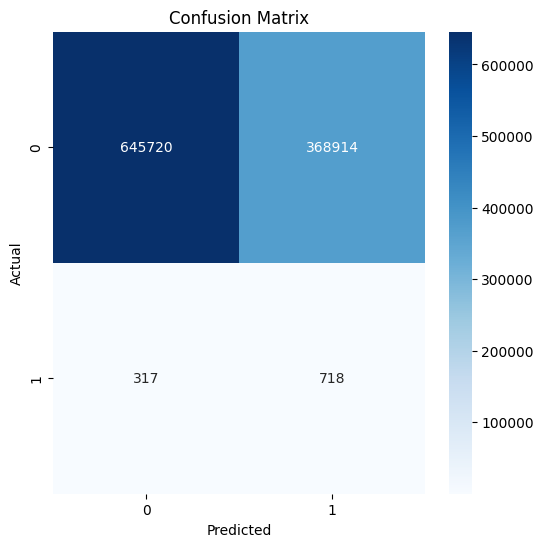

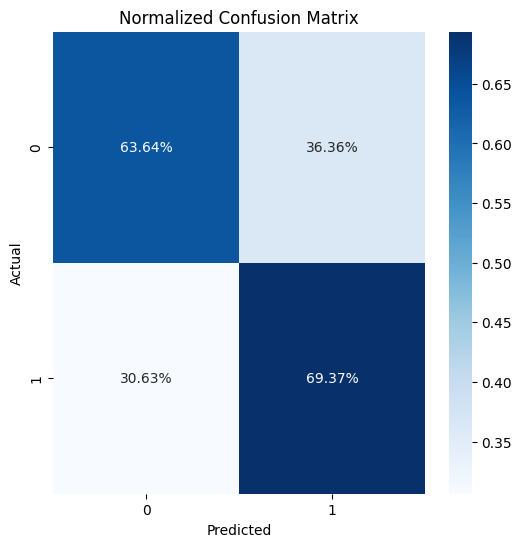

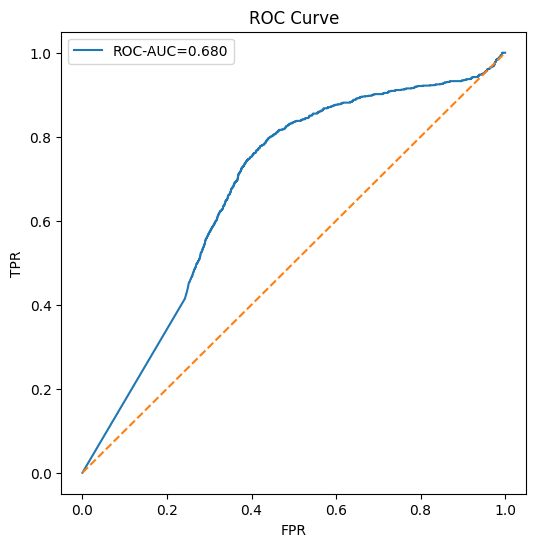

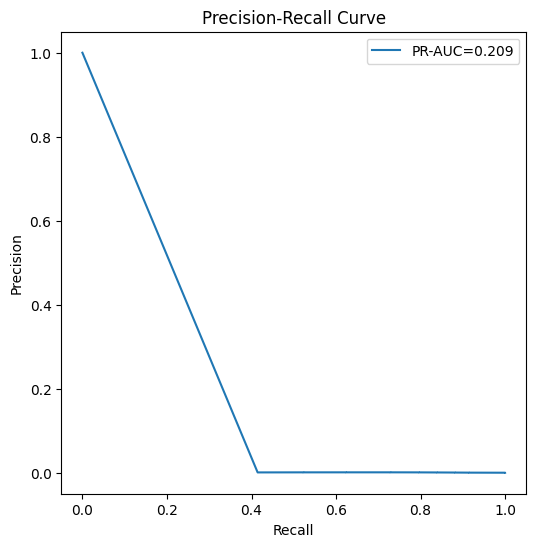

In [26]:
# train the gnn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FraudGNN(num_edge_features=edge_attr.shape[1])
# =========================
# CLASS IMBALANCE HANDLING
# =========================

fraud_count = (data.y == 1).sum().item()
normal_count = (data.y == 0).sum().item()

weights = torch.tensor(
    [1.0, normal_count / fraud_count],
    device=device
)

loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# =========================
# OPTIMIZER
# =========================

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = train_and_evaluate_gnn(
    model=model,
    data=data,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    device=device
)